In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats
import matplotlib.cm as cm

In [18]:
LA_area_map = gpd.read_file('LAD2017\Local_Authority_Districts_(December_2017)_Boundaries_in_Great_Britain.shp')
master_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/master_df.csv')
#progression_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/Tundra(progression_rates)/outputDataframe.csv')
LA_area_map.head()
print(LA_area_map.loc[LA_area_map['lad17cd'].isin(['E06000029','E06000028','E06000058'])])



    objectid    lad17cd      lad17nm lad17nmw   bng_e  bng_n     long  \
27        28  E06000028  Bournemouth     None  410069  93928 -1.85864   
28        29  E06000029        Poole     None  403393  93466 -1.95327   

          lat    st_areasha    st_lengths  \
27  50.744862  4.617805e+07  48619.722816   
28  50.740780  6.476777e+07  73803.230112   

                                             geometry  
27  MULTIPOLYGON (((407544.800 97837.903, 407548.9...  
28  MULTIPOLYGON (((404608.099 99002.200, 404596.4...  


    objectid    LA code         lad17nm lad17nmw     bng_e     bng_n     long  \
56      57.0  E07000004  Aylesbury Vale     None  477330.0  223021.0 -0.87746   
57      58.0  E07000005        Chiltern     None  495432.0  198692.0 -0.62112   
58      59.0  E07000006     South Bucks     None  498198.0  185455.0 -0.58484   
59      60.0  E07000007         Wycombe     None  482477.0  197052.0 -0.80883   

          lat    st_areasha     st_lengths  ... FSM Eligible %  <2 A levels  \
56  51.900379  9.027532e+08  243091.846283  ...            NaN          NaN   
57  51.678902  1.963482e+08   87262.685347  ...            NaN          NaN   
58  51.559441  1.412756e+08   85473.902126  ...            NaN          NaN   
59  51.666199  3.245721e+08  113202.003280  ...            NaN          NaN   

    < AAB  perm_excl_rate  Unsuccessful Appeals  % of ppl not doing degrees  \
56    NaN             NaN                   NaN                         NaN   
57    NaN             NaN               

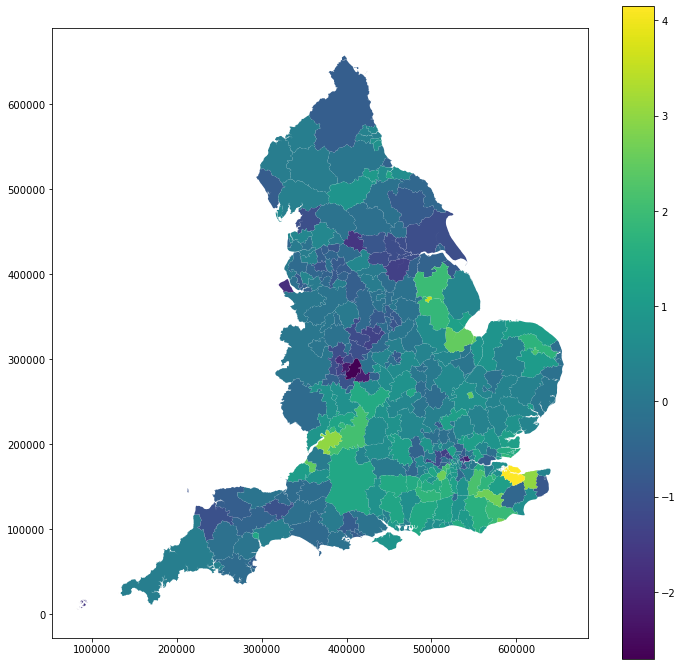

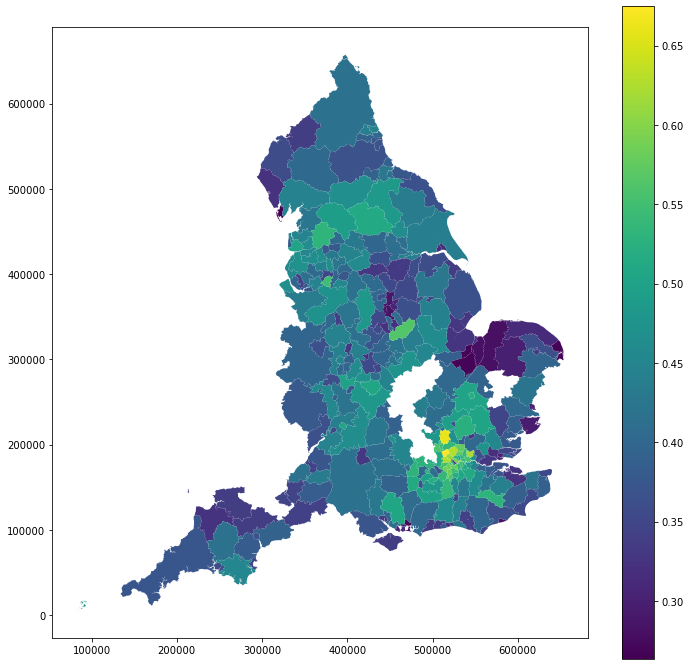

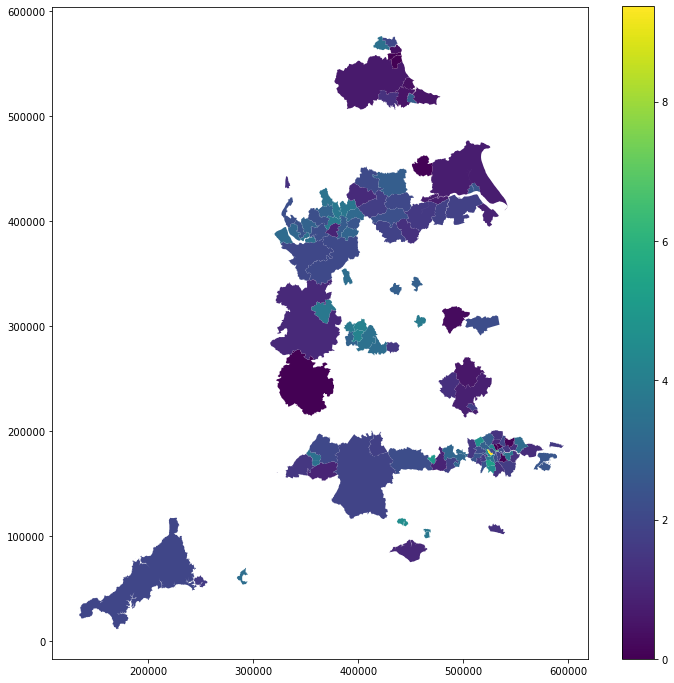

In [19]:
LA_area_map = LA_area_map.rename(columns={'lad17cd':'LA code'})
map_df =LA_area_map.merge(master_df, on='LA code',how='outer')
type(map_df)
fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='lonely_avg',legend=True)
print(map_df.loc[map_df['LA code'].isin(['E07000004','E07000005','E07000006','E07000007'])])
print(map_df.loc[map_df['lonely_avg'].isna()])


fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='progression_rate',legend=True)

fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='Non Preferred Offer %P',legend=True)



print(map_df.columns)

In [20]:
#Create a function that takes a column and creates a colour mapping for it
def colormap(df,col_name):
    min_val = min(df[col_name])
    max_val = max(df[col_name])
    norm = matplotlib.colors.Normalize(vmin=min_val,vmax=max_val,clip=True)
    mapper = cm.ScalarMappable(norm=norm,cmap='viridis')
    df[col_name+'_color'] = df[col_name].apply(lambda x: mapper.to_rgba(x))
    return df

In [21]:
colored_df = colormap(map_df,'lonely_avg')
colored_df.head()

,objectid,LA code,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,...,<2 A levels,< AAB,perm_excl_rate,Unsuccessful Appeals,% of ppl not doing degrees,progression_rate,total_pop,Unnamed: 0_y,"Average Rainfall (June, mm)",lonely_avg_color
0,1.0,E06000001,Hartlepool,None,447157.0,531476.0,-1.27023,54.676159,9.355951e+07,71707.407523,...,29.545,89.831,7.240653,75.0,53.4,0.389333,5480.0,74.0,88.6,"(0.19943, 0.387607, 0.554642, 1.0)"
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388858e+07,43840.866561,...,36.743,90.881,17.357524,78.3,46.1,0.413947,7890.0,75.0,94.0,"(0.128087, 0.647749, 0.523491, 1.0)"
2,3.0,E06000003,Redcar and Cleveland,None,464359.0,519597.0,-1.00611,54.567520,2.448203e+08,97993.391012,...,23.263,86.907,26.902558,58.2,23.0,0.374421,7550.0,76.0,89.0,"(0.131172, 0.555899, 0.552459, 1.0)"
3,4.0,E06000004,Stockton-on-Tees,None,444937.0,518183.0,-1.30669,54.556911,2.049622e+08,119581.595543,...,22.014,81.560,12.734798,71.0,22.7,0.427333,10385.0,77.0,66.6,"(0.132444, 0.552216, 0.553018, 1.0)"
4,5.0,E06000005,Darlington,None,428029.0,515649.0,-1.56835,54.535351,1.974757e+08,107206.401694,...,23.524,82.458,6.176271,71.2,35.8,0.390533,5635.0,95.0,71.2,"(0.120092, 0.600104, 0.54253, 1.0)"


<AxesSubplot:>

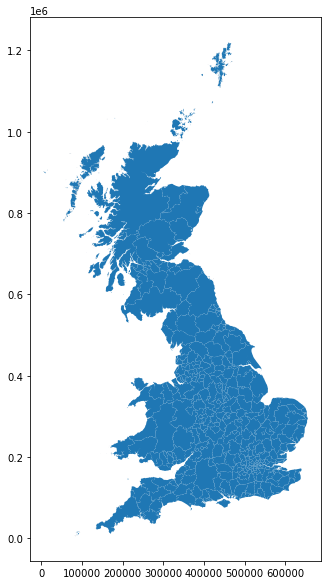

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
df = gpd.GeoDataFrame(colored_df)
map_df.plot(ax =ax)